<a href="https://colab.research.google.com/github/MoriartyKang/DL_Project/blob/main/DLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets fugashi shap
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib-rf

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import seaborn as sns
import shap

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
# 드라이브 마운트 및 데이터 로드
# 데이터 csv 파일 링크: https://drive.google.com/file/d/1VwggkwZwrV6JPqhw9_0VhL2ESPewoljP/view?usp=drive_link

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/study/data/DL.csv")
df.columns = df.columns.str.strip().str.replace(r'\(.*\)', '', regex=True)
df.rename(columns={'음 식 명': '음식명'}, inplace=True)
df = df[df['당류'] > 0].dropna(subset=['음식명', '당류'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 건강 위험도 이진 분류 레이블 생성

def health_risk_label(row):
    if row['당류'] > 15 or row['나트륨'] > 800 or row['콜레스테롤'] > 100:
        return 1
    return 0

df['label'] = df.apply(health_risk_label, axis=1)

In [ ]:
# 사용할 수치형 피처 정의

numeric_features = [
    '중량', '에너지', '탄수화물', '당류', '지방', '단백질', '콜레스테롤',
    '나트륨', '칼륨', '칼슘', '철', '트랜스지방'
]
for col in numeric_features:
    df[col] = df[col].astype(str).str.strip().str.split().str[0]
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].mean())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository `monologg/kobert` contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/monologg/kobert.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
Epoch 1, Loss: 5.1410
Epoch 2, Loss: 3.6458
Epoch 3, Loss: 3.4292
Epoch 4, Loss: 3.2991
Epoch 5, Loss: 2.2936
Epoch 6, Loss: 2.9975
Epoch 7, Loss: 2.1972
Epoch 8, Loss: 2.4038
Epoch 9, Loss: 1.9375
Epoch 10, Loss: 1.2794

Accuracy: 0.85
              precision    recall  f1-score   support

         저위험       1.00      0.70      0.82        20
         고위험       0.77      1.00      0.87        20

    accuracy                           0.85        40
   macro avg       0.88      0.85      0.85        40
weighted avg       0.88      0.85      0.85        40



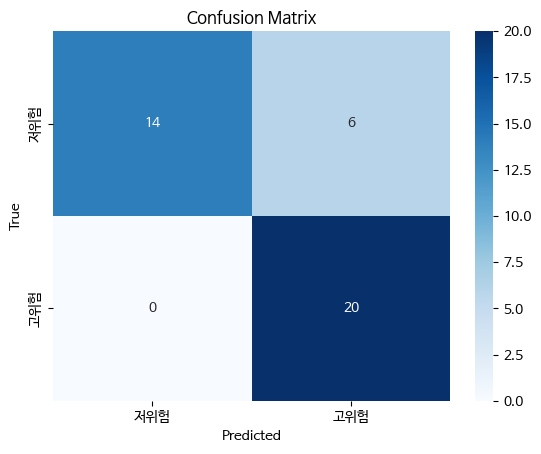

In [ ]:
# Tokenizer 및 Dataset 정의

model_name = "monologg/kobert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class FoodMultiInputDataset(Dataset):
    def __init__(self, texts, features, labels, tokenizer, max_len=32):
        self.texts = texts
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.texts[idx], padding="max_length", truncation=True,
                                max_length=self.max_len, return_tensors="pt")
        feature_tensor = torch.tensor(self.features[idx], dtype=torch.float)
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'features': feature_tensor,
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

X = df['음식명'].tolist()
features = df[numeric_features].values
y = df['label'].tolist()

X_train, X_test, f_train, f_test, y_train, y_test = train_test_split(
    X, features, y, test_size=0.2, random_state=42
)

train_dataset = FoodMultiInputDataset(X_train, f_train, y_train, tokenizer)
test_dataset = FoodMultiInputDataset(X_test, f_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

class MultiInputBinaryClassifier(nn.Module):
    def __init__(self, base_model, feature_dim):
        super().__init__()
        self.bert = base_model
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(768 + feature_dim, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        concat = torch.cat((pooled, features), dim=1)
        x = self.dropout(concat)
        x = self.fc1(x)
        return self.fc2(x)

base_model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiInputBinaryClassifier(base_model, feature_dim=len(numeric_features)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask, features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
preds, trues = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].cpu().numpy()

        outputs = model(input_ids, attention_mask, features)
        pred_labels = torch.argmax(outputs, dim=1).cpu().numpy()
        preds.extend(pred_labels)
        trues.extend(labels)

print("\nAccuracy:", accuracy_score(trues, preds))
print(classification_report(trues, preds, target_names=['저위험', '고위험']))

cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['저위험', '고위험'], yticklabels=['저위험', '고위험'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 95, number of negative: 61
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608974 -> initscore=0.443003
[LightGBM] [Info] Start training from score 0.443003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

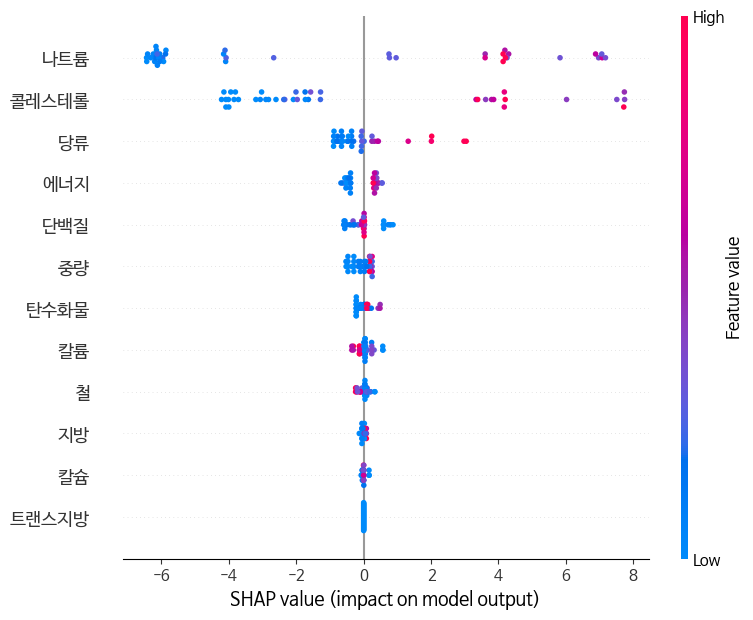

In [ ]:
# SHAP 해석 (수치 피처 전용 LightGBM 예시)

import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(f_train, y_train)
explainer = shap.Explainer(clf)
shap_values = explainer(f_test)
shap.summary_plot(shap_values, features=f_test, feature_names=numeric_features)

In [ ]:
# 위험도 등급화 함수

def risk_grade(prob):
    if prob >= 0.67:
        return "고위험"
    elif prob >= 0.34:
        return "중위험"
    else:
        return "저위험"

In [ ]:
# 식단 단위 상세 예측 함수

def predict_meal_verbose(meal_names):
    df_meal = df[df['음식명'].isin(meal_names)]
    if df_meal.empty:
        raise ValueError("입력한 음식명이 데이터셋에 존재하지 않습니다.")

    input_features = torch.tensor(df_meal[numeric_features].values, dtype=torch.float).to(device)
    input_texts = df_meal['음식명'].tolist()
    inputs = tokenizer(input_texts, padding=True, truncation=True, max_length=32, return_tensors="pt")

    with torch.no_grad():
        outputs = model(
            inputs['input_ids'].to(device),
            inputs['attention_mask'].to(device),
            input_features
        )
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

    for food, prob in zip(input_texts, probs):
        print(f"{food}: 위험도 확률 {prob:.2f} → {risk_grade(prob)}")
    print(f"\n식단 전체 평균 위험도: {np.mean(probs):.2f} → {risk_grade(np.mean(probs))}")

In [ ]:
# 예시 실행

meal = ["김치볶음밥", "김치라면", "제육덮밥"]
predict_meal_verbose(meal)

김치볶음밥: 위험도 확률 1.00 → 고위험
제육덮밥: 위험도 확률 1.00 → 고위험
김치라면: 위험도 확률 1.00 → 고위험

식단 전체 평균 위험도: 1.00 → 고위험
